# Uncertainty quantification for cross sections
This tutorial will demonstrate how to use jitr to perform uncertainty quantification of a simple reaction observable: differential elastic scattering cross sections. We will use the following uncertainty quantified optical potentials:
- KDUQ introduced here: [[Pruitt et al., 2024]](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602). 
- CHUQ also introduced here: [[Pruitt et al., 2024]](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602).
- WLH from [[Whitehead et al., 2021]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.127.182502)

     
jitR includes an implementation of each of these, as well as samples from their respecctive posteriors

In [1]:
from pathlib import Path

import corner

# import stuff for nice plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from numba import njit
from scipy import stats
from tqdm import tqdm

import jitr

In [2]:
from jitr.optical_potentials import kduq, wlh, chuq

We will use [exfor-tools](https://github.com/beykyle/exfor_tools) using an [x4i3](https://github.com/afedynitch/x4i3/) backend for grabbing data from [EXFOR](https://www-nds.iaea.org/exfor/) (requires 1GB of disk space to download).

In [3]:
#! pip install exfor-tools
import exfor_tools

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


### Let's find some data to compare to
Let's grab some data from [EXFOR](https://www-nds.iaea.org/exfor/). We will look at $d\sigma_{el}/d\Omega$ for $(n,n)$ and $(p,p)$.

In [4]:
# target to consider
Pb208 = (208, 82)
proton = (1, 1)
neutron = (1, 0)

# for plotting differential xs
angles = np.linspace(0.1, np.pi, 100)

In [5]:
all_entries, failed_parses = exfor_tools.curate.query_for_entries(
    exfor_tools.reaction.ElasticReaction(target=Pb208, projectile=(1, 0)),
    quantity="dXS/dA",
    Einc_range=[7, 60],  # MeV
)
all_measurements = exfor_tools.curate.categorize_measurements_by_energy(all_entries)

In [6]:
all_entries.keys()

dict_keys(['10871', '12865', '12903', '13531', '13635', '13685'])

In [7]:
all_entries_Ay, failed_parses = exfor_tools.curate.query_for_entries(
    exfor_tools.reaction.Reaction(target=Pb208, projectile=(1, 0), process="EL"),
    quantity="Ay",
    Einc_range=[7, 60],  # MeV
)
all_measurements_Ay = exfor_tools.curate.categorize_measurements_by_energy(
    all_entries_Ay
)

In [8]:
all_measurements_Ay

[[<exfor_tools.distribution.AngularDistribution at 0x7b4ae2484d90>,

(0.0, 205.0)

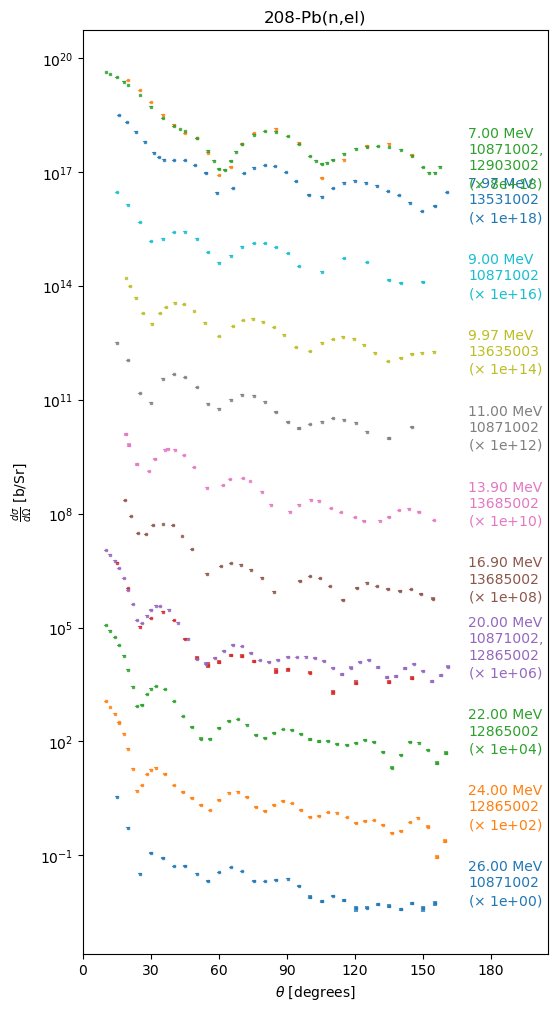

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
exfor_keys = list(all_entries.keys())
exfor_tools.distribution.AngularDistribution.plot(
    all_measurements,
    ax,
    offsets=100,
    data_symbol=list(all_entries.values())[0].data_symbol,
    rxn_label=list(all_entries.values())[0].reaction.reaction_string,
    label_kwargs={
        "label_offset_factor": 0.005,
        "label_offset": True,
        "label_exfor": True,
        "label_xloc_deg": 170,
        "label_energy_err": False,
    },
)
ax.set_xlim([0, 205])

(0.0, 205.0)

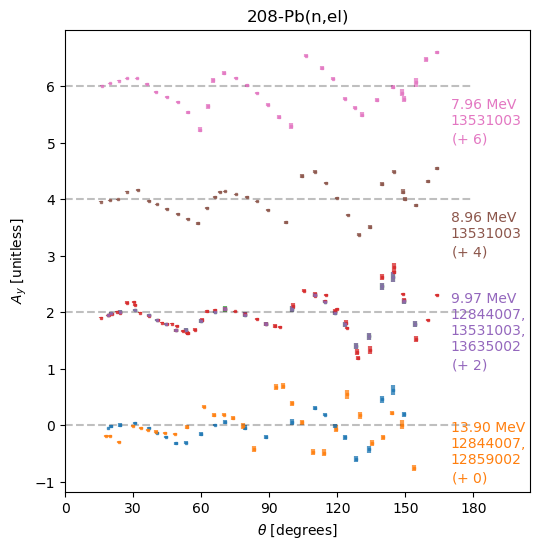

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
exfor_keys = list(all_entries_Ay.keys())
exfor_tools.distribution.AngularDistribution.plot(
    all_measurements_Ay,
    ax,
    offsets=2,
    data_symbol=list(all_entries_Ay.values())[0].data_symbol,
    rxn_label=list(all_entries_Ay.values())[0].reaction.reaction_string,
    draw_baseline=True,
    baseline_offset=0,
    log=False,
    label_kwargs={
        "label_offset_factor": -1,
        "label_offset": True,
        "label_exfor": True,
        "label_xloc_deg": 170,
        "label_energy_err": False,
    },
)
ax.set_xlim([0, 205])

### Let's set up our solver to calculate $^{208}$Pb $(n,n)$ differential cross sections

In [11]:
solvers = []
core_solver = jitr.rmatrix.Solver(40)
reaction = jitr.reactions.ElasticReaction(
    target=Pb208,
    projectile=(1, 0),
)


for measurements in all_measurements:
    measurement = measurements[0]
    Elab = measurement.Einc

    # get kinematics and parameters for this experiment
    kinematics = reaction.kinematics(Elab)

    a = jitr.utils.interaction_range(208) * kinematics.k + np.pi * 2
    N = jitr.utils.suggested_basis_size(a)
    assert N < core_solver.kernel.quadrature.nbasis
    channel_radius_fm = a / kinematics.k

    solvers.append(
        jitr.xs.elastic.DifferentialWorkspace.build_from_system(
            reaction=reaction,
            kinematics=kinematics,
            channel_radius_fm=channel_radius_fm,
            solver=core_solver,
            lmax=20,
            angles=angles,
        )
    )

# Now that we have the solvers set up, let's run the UQ!

### First let's grab posterior samples from each of our optical potentials

In [ ]:
kduq_samples = kduq.get_samples_federal(neutron)
chuq_samples = chuq.get_samples_federal(neutron)
wlh_samples = wlh.get_samples(neutron)

## KDUQ:

In [13]:
kduq_pred_post = []
kduq_pred_post_Ay = []

for i in range(len(all_measurements)):
    # get a differential xs for each parameter sample
    kduq_xs = np.zeros((len(angles), kduq.NUM_POSTERIOR_SAMPLES))
    kduq_ay = np.zeros((len(angles), kduq.NUM_POSTERIOR_SAMPLES))

    for j, sample in enumerate(tqdm(kduq_samples)):
        coulomb_params, central_params, spin_orbit_params = kduq.calculate_params(
            neutron, Pb208, solvers[i].kinematics.Elab, *sample
        )

        xs = solvers[i].xs(
            kduq.central,
            kduq.spin_orbit,
            central_params,
            spin_orbit_params,
        )
        kduq_xs[:, j] = xs.dsdo
        kduq_ay[:, j] = xs.Ay

    # get credible intervals describing the KDUQ predictive posterior
    # for this experiment
    kduq_pred_post.append(np.percentile(kduq_xs, [5, 95], axis=1))
    kduq_pred_post_Ay.append(np.percentile(kduq_ay, [5, 95], axis=1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:01<00:00, 403.87it/s]


## CHUQ:

In [14]:
chuq_pred_post = []
chuq_pred_post_Ay = []

for i in range(len(all_measurements)):
    # get a differential xs for each parameter sample
    chuq_xs = np.zeros((len(angles), chuq.NUM_POSTERIOR_SAMPLES))
    chuq_ay = np.zeros((len(angles), chuq.NUM_POSTERIOR_SAMPLES))

    for j, sample in enumerate(tqdm(chuq_samples)):
        coulomb_params, central_params, spin_orbit_params = chuq.calculate_params(
            neutron, Pb208, solvers[i].kinematics.Elab, *sample
        )
        
        xs = solvers[i].xs(
            chuq.central,
            chuq.spin_orbit,
            central_params,
            spin_orbit_params,
        )
        chuq_xs[:, j] = xs.dsdo
        chuq_ay[:, j] = xs.Ay

    # get credible intervals describing the KDUQ predictive posterior
    # for this experiment
    chuq_pred_post.append(np.percentile(chuq_xs, [5, 95], axis=1))
    chuq_pred_post_Ay.append(np.percentile(chuq_ay, [5, 95], axis=1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 406.13it/s]


In [16]:
wlh_pred_post = []
wlh_pred_post_Ay = []

for i in range(len(all_measurements)):
    # get a differential xs for each parameter sample
    wlh_xs = np.zeros((len(angles), wlh.NUM_POSTERIOR_SAMPLES))
    wlh_ay = np.zeros((len(angles), wlh.NUM_POSTERIOR_SAMPLES))

    for j, sample in enumerate(tqdm(wlh_samples)):
        coulomb_params, central_params, spin_orbit_params = wlh.calculate_params(
            neutron, Pb208, solvers[i].kinematics.Elab, *sample
        )
        
        xs = solvers[i].xs(
            wlh.central,
            wlh.spin_orbit,
            central_params,
            spin_orbit_params,
        )
        wlh_xs[:, j] = xs.dsdo
        wlh_ay[:, j] = xs.Ay

    # get credible intervals describing the KDUQ predictive posterior
    # for this experiment
    wlh_pred_post.append(np.percentile(wlh_xs, [5, 95], axis=1))
    wlh_pred_post_Ay.append(np.percentile(wlh_ay, [5, 95], axis=1))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 410.38it/s]


Now that we have our model predictions, lets plot them compared to the experimental data. We will offset each energy for visibility.

In [17]:
cd = chuq.Global(neutron, jitr.data.data_dir / "CH89_default.json")
cd.params

OrderedDict([('V0', 52.9),
             ('Ve', -0.299),
             ('Vt', 13.1),
             ('r0', 1.25),
             ('r0_0', -0.225),
             ('a0', 0.69),
             ('Wv0', 7.8),
             ('Wve0', 35.0),
             ('Wvew', 16.0),
             ('rw', 1.33),
             ('rw_0', -0.42),
             ('aw', 0.69),
             ('Ws0', 10.0),
             ('Wst', 18.0),
             ('Wse0', 36.0),
             ('Wsew', 37.0),
             ('Vso', 5.9),
             ('rso', 1.34),
             ('rso_0', -1.2),
             ('aso', 0.63),
             ('rc', 1.24),
             ('rc_0', 0.12)])

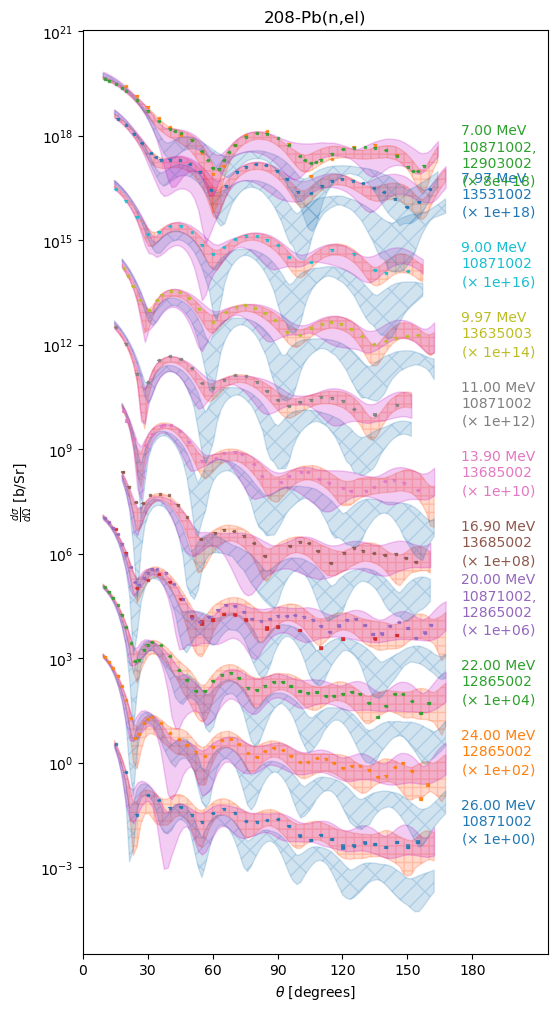

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
offsets = exfor_tools.distribution.AngularDistribution.plot(
    all_measurements,
    ax,
    offsets=100,
    data_symbol=list(all_entries.values())[0].data_symbol,
    rxn_label=list(all_entries.values())[0].reaction.reaction_string,
    label_kwargs={
        "label_offset_factor": 0.005,
        "label_offset": True,
        "label_exfor": True,
        "label_xloc_deg": 175,
        "label_energy_err": False,
    },
)
ax.set_xlim([0, 215])

for i in range(len(all_measurements)):
    xmin = min([np.min(m.x) for m in all_measurements[i]]) * np.pi / 180
    xmax = max([np.max(m.x) for m in all_measurements[i]]) * np.pi / 180
    mask = np.logical_and(angles >= xmin * 0.9, angles < xmax * 1.05)

    # plot models
    ax.fill_between(
        angles[mask] * 180 / np.pi,
        offsets[i] * kduq_pred_post[i][0][mask] / 1000,
        offsets[i] * kduq_pred_post[i][1][mask] / 1000,
        color="#ff4500",
        hatch='|-|-',
        alpha=0.2,
    )
    ax.fill_between(
        angles[mask] * 180 / np.pi,
        offsets[i] * chuq_pred_post[i][0][mask] / 1000,
        offsets[i] * chuq_pred_post[i][1][mask] / 1000,
        color="tab:blue",
        hatch="/\/",
        alpha=0.2,
    )
    ax.fill_between(
        angles[mask] * 180 / np.pi,
        offsets[i] * wlh_pred_post[i][0][mask] / 1000,
        offsets[i] * wlh_pred_post[i][1][mask] / 1000,
        color="m",
        alpha=0.2,
    )

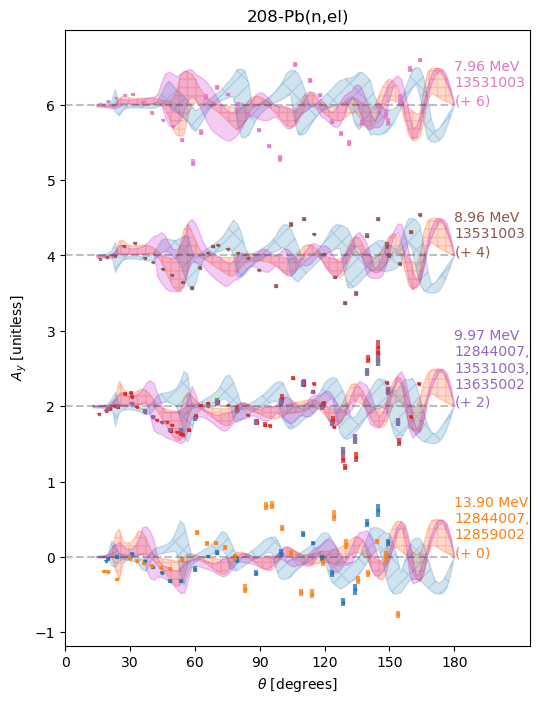

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
exfor_keys = list(all_entries_Ay.keys())
offsets = exfor_tools.distribution.AngularDistribution.plot(
    all_measurements_Ay,
    ax,
    offsets=2,
    data_symbol=list(all_entries_Ay.values())[0].data_symbol,
    rxn_label=list(all_entries_Ay.values())[0].reaction.reaction_string,
    draw_baseline=True,
    baseline_offset=0,
    log=False,
    label_kwargs={
        "label_offset_factor": 0,
        "label_offset": True,
        "label_exfor": True,
        "label_xloc_deg": 180,
        "label_energy_err": False,
    },
)
ax.set_xlim([0, 215])
for i in range(len(all_measurements_Ay)):
    # get x_range
    xmin = min([np.min(m.x) for m in all_measurements_Ay[i]]) * np.pi / 180
    xmax = max([np.max(m.x) for m in all_measurements_Ay[i]]) * np.pi / 180
    mask = np.logical_and(angles >= xmin * 0.8, angles < xmax * 1.2)
    # plot models
    ax.fill_between(
        angles[mask] * 180 / np.pi,
        offsets[i] + kduq_pred_post_Ay[i][0][mask],
        offsets[i] + kduq_pred_post_Ay[i][1][mask],
        color="#ff4500",
        hatch='|-|-',
        alpha=0.2,
    )
    ax.fill_between(
        angles[mask] * 180 / np.pi,
        offsets[i] + chuq_pred_post_Ay[i][0][mask],
        offsets[i] + chuq_pred_post_Ay[i][1][mask],
        color="tab:blue",
        hatch="/\/",
        alpha=0.2,
    )
    ax.fill_between(
        angles[mask] * 180 / np.pi,
        offsets[i] + wlh_pred_post_Ay[i][0][mask],
        offsets[i] + wlh_pred_post_Ay[i][1][mask],
        color="m",
        alpha=0.2,
    )